In [1]:
import time
import requests
import numpy as np
import pandas as pd
import yfinance as yf
from talib import abstract
import mplfinance as mpf
import matplotlib.pyplot as plt
from datetime import datetime
import mplfinance as mpf
import pandas_datareader as data

In [2]:
# # DataFrame Setting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)
pd.set_option('display.width', 5000)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

# # Global Variables Setting
symbol = 'BTCUSDT'
url = 'https://api.binance.com/'

# # Get Market Data
def GetKline(url, symbol, interval, startTime = None, endTime = None):
    try:
        data = requests.get(url + 'api/v3/klines', params={'symbol': symbol, 'interval': interval, 'startTime': startTime, 'limit': 1000}).json()
    except Exception as e:
        print ('Error! problem is {}'.format(e.args[0]))
    tmp  = []
    pair = []
    for base in data:
        tmp  = []
        for i in range(0,6):
            if i == 0:
                base[i] = datetime.fromtimestamp(base[i]/1000)
            tmp.append(base[i])
        pair.append(tmp)
    df = pd.DataFrame(pair, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df.date = pd.to_datetime(df.date)
    df.set_index("date", inplace=True)
    df = df.astype(float)
    return df

def GetHistoricalKline(url, symbol, interval, startTime):
    # init
    klines = GetKline(url, symbol, interval)
    tmptime = ToMs(klines.iloc[0].name)
    
    # Send request until tmptime > startTime
    while tmptime > startTime:
        tmptime -= PeriodToMs(interval) * 1000 # tmp minus period ms plus 1000 (1000 K)
        if tmptime < startTime:
            tmptime = startTime
        tmpdata = GetKline(url, symbol, interval, tmptime)
        klines  = pd.concat([tmpdata, klines])

    return klines.drop_duplicates(keep='first', inplace=False)

# Math Tools
def ToMs(date):
    return int(time.mktime(time.strptime(str(date), "%Y-%m-%d %H:%M:%S")) * 1000) # Binance timestamp format is 13 digits

def PeriodToMs(period):
    Ms = None
    ToSeconds = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }
    unit = period[-1]

    if unit in ToSeconds:
        try:
            Ms = int(period[:-1]) * ToSeconds[unit] * 1000
        except ValueError:
            pass
    return Ms



if __name__ == "__main__":
    klines = GetKline(url, symbol, '1d', ToMs('2021-01-01 08:00:00'))

In [3]:
def RSI(df, period):
    return abstract.RSI(df, timeperiod=period)

In [4]:
stock_num = "BTC-USD"
stock = yf.Ticker(stock_num)
startDate = "2021-01-01"
stock_df = pd.DataFrame(stock.history(start=startDate))
stock_df = stock_df.reset_index()
stock_df['EMA_12'] = stock_df['Close'].ewm(span=12, adjust=False).mean()
stock_df['EMA_26'] = stock_df['Close'].ewm(span=26, adjust=False).mean()
stock_df['DIF'] = stock_df['EMA_12'] - stock_df['EMA_26']
stock_df['MACD'] = stock_df['DIF'].ewm(span=9, adjust=False).mean()
stock_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA_12,EMA_26,DIF,MACD
0,2020-12-31,28841.574219,29244.876953,28201.992188,29001.720703,46754964848,0,0,29001.720703,29001.720703,0.000000,0.000000
1,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,40730301359,0,0,29059.017879,29029.308232,29.709647,5.941929
2,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,67865420765,0,0,29531.056294,29258.786702,272.269592,59.207462
3,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,78665235202,0,0,30031.205085,29519.767201,511.437884,149.653546
4,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,81163475344,0,0,30329.775697,29701.407709,628.367988,245.396435


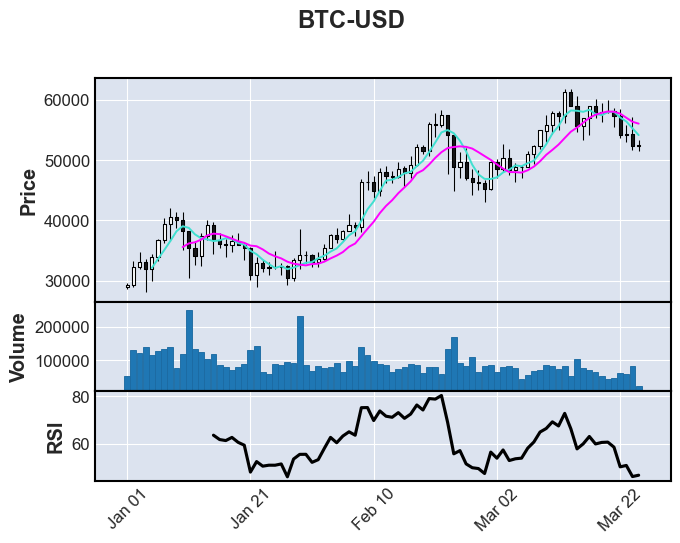

In [5]:
index  = mpf.make_addplot(RSI(klines, 14), panel = 2, ylabel = 'RSI', color = 'black')
mpf.plot(klines, type = 'candle', mav=(5,10),title = 'BTC-USD',addplot = [index],volume = True)

c:\users\fetty\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


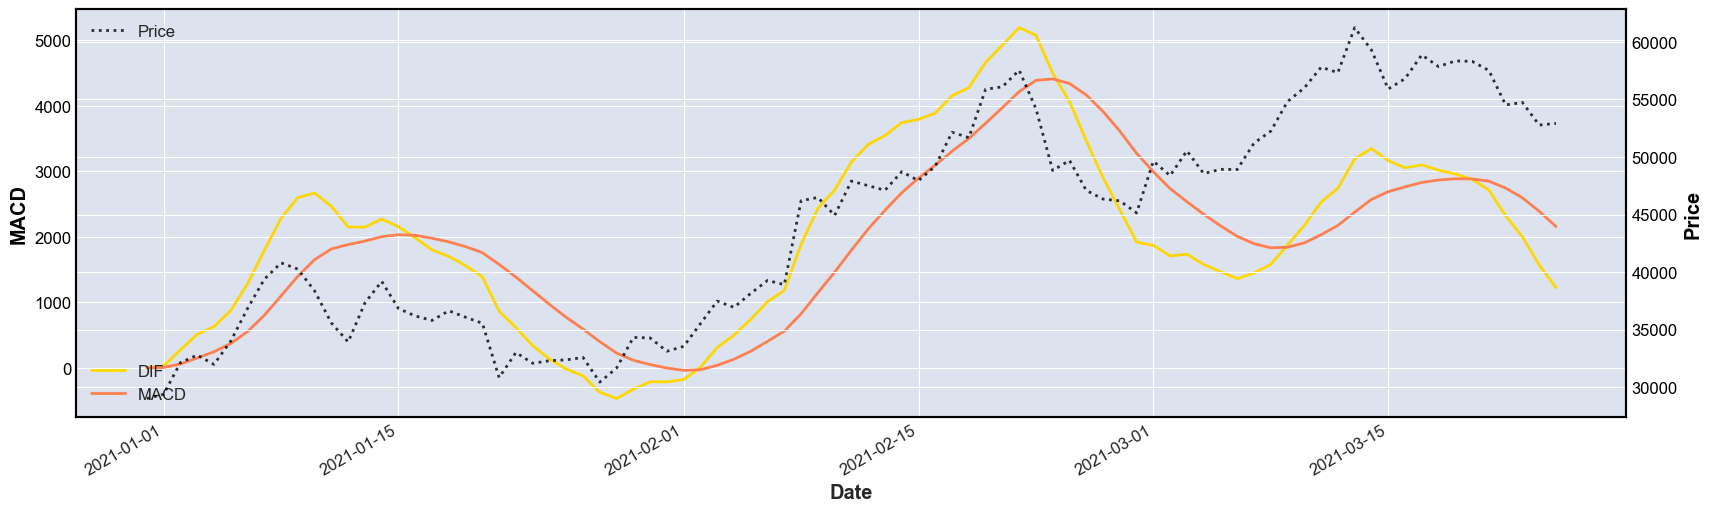

In [7]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 6)
plt.xlabel('Date')
ax2 = ax1.twinx()
# macd & dif
ax1.set_ylabel('MACD', color='black')
ax1.plot(stock_df['Date'], stock_df['DIF'], color='gold', label="DIF", alpha=1)
ax1.plot(stock_df['Date'], stock_df['MACD'], color='coral', label="MACD", alpha=1)
ax1.legend(loc="lower left")
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)
# price
ax2.set_ylabel('Price', color='black')
ax2.plot(stock_df['Date'], stock_df['Close'], color='black', label="Price", linestyle=':', alpha=0.8)
ax2.legend(loc="upper left")
ax2.tick_params(axis='y', labelcolor='black')
fig.autofmt_xdate()
fig.show()